In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
#import global_variable
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/vgg16-weights"))
#print(os.listdir("../input/dogs-vs-cats-redux-kernels-edition/train"))
# Any results you write to the current directory are saved as output.

['vgg16-weights', 'dogs-vs-cats-redux-kernels-edition']
['vgg16_weights.npz']


In [2]:
#os.path.exists("../input/dogs-vs-cats-redux-kernels-edition/test/1.jpg")

In [3]:
#os.path.exists("../input/dogs-vs-cats-redux-kernels-edition/test/test") #这就是问题！

In [4]:
class vgg16():
    def __init__(self):
        self.params=[]
    def build(self,imgs):
        self.conv1_1 = self.conv("conv1re_1",imgs,64)
        self.conv1_2 = self.conv("conv1_2",self.conv1_1,64)
        self.pool1 = self.maxpool("poolre1",self.conv1_2)

        #conv2
        self.conv2_1 = self.conv("conv2_1",self.pool1,128)
        self.conv2_2 = self.conv("convwe2_2",self.conv2_1,128)
        self.pool2 = self.maxpool("pool2",self.conv2_2)

        #conv3
        self.conv3_1 = self.conv("conv3_1",self.pool2,256)
        self.conv3_2 = self.conv("convrwe3_2",self.conv3_1,256)
        self.conv3_3 = self.conv("convrew3_3",self.conv3_2,256)
        self.pool3 = self.maxpool("poolre3",self.conv3_3)

        #conv4
        self.conv4_1 = self.conv("conv4_1",self.pool3,512)
        self.conv4_2 = self.conv("convrwe4_2",self.conv4_1,512)
        self.conv4_3 = self.conv("conv4rwe_3",self.conv4_2,512)
        self.pool4 = self.maxpool("pool4",self.conv4_3)


        #conv5
        self.conv5_1 = self.conv("conv5_1",self.pool4,512)
        self.conv5_2 = self.conv("convrwe5_2",self.conv5_1,512)
        self.conv5_3 = self.conv("conv5_3",self.conv5_2,512)
        self.pool5 = self.maxpool("poorwel5",self.conv5_3)

        #fc
        self.fc6 = self.fc("fc6", self.pool5, 4096) #,trainable=False)
        self.fc7 = self.fc("fc7", self.fc6, 4096) #=False)
        self.fc8 = self.fc("fc8", self.fc7, 2)    #1
        
        self.probs=self.fc8
        
    def maxpool(self,name,input_data):
        out = tf.nn.max_pool(input_data,[1,2,2,1],[1,2,2,1],padding="SAME",name=name)
        return out
    
    def conv(self,name, input_data, out_channel, trainable=False):
        in_channel = input_data.get_shape()[-1]
        with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
            kernel = tf.get_variable("weights", [3, 3, in_channel, out_channel], dtype=tf.float32,trainable=False)
            biases = tf.get_variable("biases", [out_channel], dtype=tf.float32,trainable=False)
            conv_res = tf.nn.conv2d(input_data, kernel, [1, 1, 1, 1], padding="SAME")
            res = tf.nn.bias_add(conv_res, biases)
            out = tf.nn.relu(res, name=name)
        self.params += [kernel, biases]
        return out
    
    def fc(self,name,input_data,out_channel,trainable = True):
        
        shape = input_data.get_shape().as_list()
        if len(shape) == 4:
            size = shape[-1] * shape[-2] * shape[-3]
        else:
            size = shape[1]
        input_data_flat = tf.reshape(input_data,[-1,size])
        
        #input_data_flat =tf.layers.Flatten()(input_data)  #size有用
        
        with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
            weights = tf.get_variable(name="weights",shape=[size,out_channel],dtype=tf.float32,trainable = trainable,initializer=tf.glorot_normal_initializer())
            biases = tf.get_variable(name="biases",shape=[out_channel],dtype=tf.float32,trainable = trainable)
            res = tf.matmul(input_data_flat,weights)
            out = tf.nn.relu(tf.nn.bias_add(res,biases))
            #试一下正则化
            if trainable == True:
                tf.add_to_collection('losses',tf.contrib.layers.l2_regularizer(0.5)(weights))#试一下lambda:0.5-->0.4
        self.params += [weights, biases]
        return out
    
    def load_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if i not in [26,27,28,29,30,31]:
                sess.run(self.params[i].assign(weights[k]))
        print("-----------all done---------------")
    
    def saver(self):
        return tf.train.Saver()


In [5]:
def get_file(path):    #path以'/'结尾
    img_list=[]
    label_list=[]
    for img in os.listdir(path):
        
        species=img.split('.')[0]
        if species=='cat':
            label_list.append(0)
            img_list.append(path+img)
        elif species=='dog':
            label_list.append(1)
            img_list.append(path+img)
    """
    state=np.random.get_state()
    np.random.shuffle(img_list)
    np.random.set_state(state)
    np.random.shuffle(label_list)
    """
    return img_list,label_list


In [6]:
"""
a=[[1,2]]
print(a[0][1])
"""

'\na=[[1,2]]\nprint(a[0][1])\n'

In [7]:
def aug(img):
    if img.dtype!=tf.float32:
        img=tf.image.convert_image_dtype(img,dtype=tf.float32)
    img=tf.image.random_flip_left_right(img)
    img=tf.image.random_flip_up_down(img)
    #调整颜色没有写
    return img

In [8]:
def get_batch(img_list,label_list,batch_size,capacity,w=224,h=224):
    img_list=tf.cast(img_list,tf.string)
    label_list=tf.cast(label_list,tf.int32)
    
    queue=tf.train.slice_input_producer([img_list,label_list],shuffle=True,num_epochs=5)
    label=queue[1]
    img=queue[0]
    img=tf.read_file(img)
    img=tf.image.decode_jpeg(img,channels=3)
    
    img = tf.image.resize_image_with_crop_or_pad(img,w,h)
    #img = tf.image.per_image_standardization(img)    #这句话有问题？对，因为生成测试数据时没有这么处理。
    #我觉得这里还要加一个数据增强的步骤，否则这么多数据过拟合
    #img=aug(img)   #卷积具有平移不变性，所以应该没有大作用？
    img_batch,label_batch=tf.train.batch([img,label],batch_size=batch_size,capacity=capacity,num_threads=64,allow_smaller_final_batch=True)
    #label_batch=tf.reshape.....
    return img_batch,label_batch
    
    

In [9]:
#tf.cast([1,0,1],tf.int32)

In [10]:
imgs,labels=get_file('../input/dogs-vs-cats-redux-kernels-edition/train/')
imgs_batch,labels_batch=get_batch(imgs,labels,32,25)

In [11]:
#imgs.index('../input/dogs-vs-cats-redux-kernels-edition/train/train')  #他和 error

In [12]:
x=tf.placeholder(tf.float32,[None,224,224,3])
y=tf.placeholder(tf.int32,[None])

model=vgg16()
model.build(x)   #注意是x
p=model.probs

pred=tf.nn.softmax(p)

cross_entropy=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=p,labels=y)  #注意事项很多！
loss=tf.reduce_mean(cross_entropy)
loss+=tf.add_n(tf.get_collection('losses'))
train_op=tf.train.AdamOptimizer(0.00001).minimize(loss)


In [13]:
"""
a=np.array([[1,1],[2,3]])
print(a)
"""

'\na=np.array([[1,1],[2,3]])\nprint(a)\n'

In [14]:
train_loss=[]

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    model.load_weights('../input/vgg16-weights/vgg16_weights.npz',sess)
    saver=model.saver()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess,coord)
    
    #import time
    #start=time.time()
    #for i in range(200):      #不好 
    try:
        while not coord.should_stop():
            i_b,l_b=sess.run([imgs_batch,labels_batch])  #别忘了        
            loss2,_=sess.run([loss,train_op],feed_dict={x:i_b,y:l_b})
            train_loss.append(loss2)
            #print(tmp)
            
            #print('loss:%f'%(loss2))  #sess左右不可重名
            #end=time.time()
            #print('time:%f'%(start-end))
            #start=end
            #print('epoch %d finish'%(i))
    except tf.errors.OutOfRangeError:
        print('Done training')
    finally:    #肯定要执行
        coord.request_stop()
        #print('done')
    print('done')
    coord.join(threads)
    saver.save(sess,'./model_save')


-----------all done---------------
Done training
done


In [16]:
import matplotlib.pyplot as plt

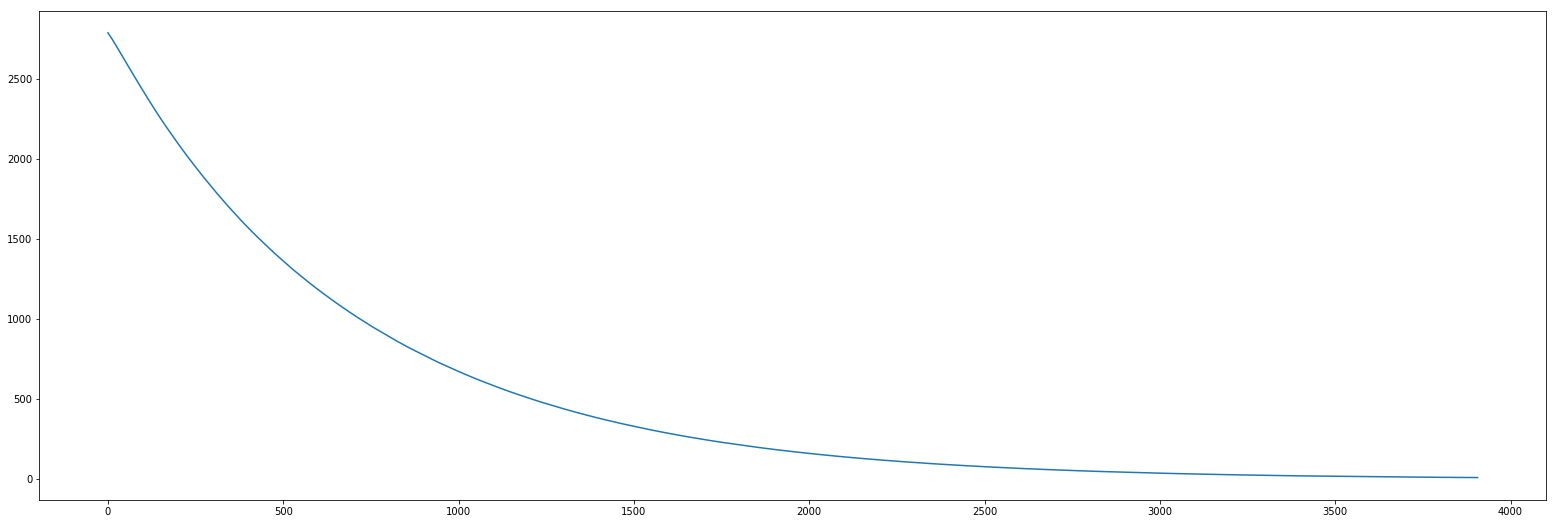

In [17]:
plt.figure(figsize=(27,9))
plt.plot(np.arange(0,len(train_loss)),train_loss)

In [18]:
def get_test(path):
    img_path=[]
    img_id=[]
    for file in os.listdir(path):
        id=file.split('.')[0]
        if id !='test':
            img_path.append(path+file)
            img_id.append(id)
    return img_path,img_id


In [19]:
img_path,img_id=get_test("../input/dogs-vs-cats-redux-kernels-edition/test/")

In [20]:
img_p=[]

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    saver=model.saver()
    saver.restore(sess,'./model_save')
    print('load done')
    for i in img_path:
        img=cv2.imread(i)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(224,224))
        #img=tf.image.per_image_standardization(img)  #看来函数中tensor与np可以混用
        #img2=sess.run(img)
        pre=sess.run(pred,feed_dict={x:[img]})  #img2
        pre=pre[0][1]
        #print(pre)
        img_p.append(pre)
        

load done


In [22]:
result=pd.DataFrame({'id':img_id,'label':img_p})
result.to_csv('myresult.csv',index=False)